# Código utilizado

In [47]:
pip install phik

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, List, Tuple
import phik


def plot_boxplots(df: pd.DataFrame, target_col: str):
    """
    Genera boxplots agrupados para comparar la distribución de columnas numéricas
    en el universo, la clase 1 y la clase 2.
    """
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if not numerical_cols:
        print("No se encontraron columnas numéricas.")
        return

    if target_col not in df.columns or df[target_col].nunique() < 2:
        print(f"La columna '{target_col}' no es válida o no tiene al menos dos clases.")
        return

    unique_labels = df[target_col].unique()
    label1, label2 = unique_labels[0], unique_labels[1]

    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        # Obtener los datos para cada grupo
        data_full = df[col].dropna()
        data_label1 = df[df[target_col] == label1][col].dropna()
        data_label2 = df[df[target_col] == label2][col].dropna()

        ax = axes[i]

        # Posiciones de los boxplots
        positions = [1, 2.5, 4]
        colors = ['midnightblue', 'palegreen', 'lightsteelblue']

        # Graficar los boxplots en el mismo eje
        bp = ax.boxplot([data_full, data_label1, data_label2],
                        positions=positions,
                        widths=0.6,
                        patch_artist=True,  # Permite colorear los cuadros
                        manage_ticks=True)

        # Asignar colores a los boxplots
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        ax.set_title(f'Distribución de {col}')
        ax.set_xticks(positions)
        ax.set_xticklabels(['Universo', f'Clase {label1}', f'Clase {label2}'])
        ax.set_ylabel(col)
        ax.grid(True)

    # Eliminar subplots no utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_categoricalDistribution(df: pd.DataFrame, target_col: str):
    """
    Analiza y visualiza en gráficos de barras valores categóricos del universo y las dos clases.
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if not categorical_cols:
        print("No se encontraron columnas categóricas.")
        return

    if target_col not in df.columns or df[target_col].nunique() != 2:
        print(f"La columna '{target_col}' no es válida o no tiene exactamente dos clases.")
        return

    unique_labels = df[target_col].unique()
    label1, label2 = unique_labels[0], unique_labels[1]

    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        ax = axes[i]

        counts_full = df[col].value_counts().reset_index()
        counts_full.columns = [col, 'Recuento']
        counts_full['Grupo'] = 'Universo'

        counts_label1 = df[df[target_col] == label1][col].value_counts().reset_index()
        counts_label1.columns = [col, 'Recuento']
        counts_label1['Grupo'] = f'Etiqueta_{label1}'

        counts_label2 = df[df[target_col] == label2][col].value_counts().reset_index()
        counts_label2.columns = [col, 'Recuento']
        counts_label2['Grupo'] = f'Etiqueta_{label2}'

        df_plot = pd.concat([counts_full, counts_label1, counts_label2])

        sns.barplot(x=col, y='Recuento', data=df_plot, hue='Grupo', ax=ax,
                    palette={'Universo': 'midnightblue',
                             f'Etiqueta_{label1}': 'palegreen',
                             f'Etiqueta_{label2}': 'lightsteelblue'})

        ax.set_title(f'Distribución de {col} por Grupo')
        ax.set_xlabel(col)
        ax.set_ylabel('Recuento')
        ax.tick_params(axis='x', rotation=45)
        plt.setp(ax.get_xticklabels(), ha='right')
        ax.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



def plot_missingValues(df: pd.DataFrame, target_col: str):
    """
    Analiza y visualiza en subplots el porcentaje de valores nulos para las columnas que los contienen.
    """
    cols_with_missing_values = df.columns[df.isnull().any()].tolist()

    cols_to_analyze = [col for col in cols_with_missing_values if col != target_col]

    if not cols_to_analyze:
        print("El DataFrame no contiene columnas con valores nulos para analizar, excluyendo la columna de etiqueta.")
        return

    if target_col not in df.columns or df[target_col].nunique() < 2:
        print(f"La columna '{target_col}' no es válida o no tiene al menos dos clases.")
        return

    unique_labels = df[target_col].unique()
    label1, label2 = unique_labels[0], unique_labels[1]

    null_percentages_full = df[cols_to_analyze].isnull().sum() / len(df) * 100
    null_percentages_label1 = df[df[target_col] == label1][cols_to_analyze].isnull().sum() / len(df[df[target_col] == label1]) * 100
    null_percentages_label2 = df[df[target_col] == label2][cols_to_analyze].isnull().sum() / len(df[df[target_col] == label2]) * 100

    n_cols = 3
    n_rows = (len(cols_to_analyze) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    color_palette = {'Universo': 'midnightblue',
                     f'Clase_{label1}': 'palegreen',
                     f'Clase_{label2}': 'lightsteelblue'}

    for i, col in enumerate(cols_to_analyze):
        ax = axes[i]

        data_for_plot = pd.DataFrame({
            'Grupo': ['Universo', f'Clase_{label1}', f'Clase_{label2}'],
            'Porcentaje de nulos': [null_percentages_full.loc[col],
                                     null_percentages_label1.loc[col],
                                     null_percentages_label2.loc[col]]
        })

        sns.barplot(x='Grupo', y='Porcentaje de nulos', data=data_for_plot, ax=ax, palette=color_palette, hue='Grupo', legend=False)

        ax.set_title(f'Nulos en {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Porcentaje de nulos')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y')
        plt.setp(ax.get_xticklabels(), ha='right')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    handles = [plt.Rectangle((0,0),1,1, color=color_palette['Universo']),
               plt.Rectangle((0,0),1,1, color=color_palette[f'Clase_{label1}']),
               plt.Rectangle((0,0),1,1, color=color_palette[f'Clase_{label2}'])]
    labels = ['Universo', f'Clase_{label1}', f'Clase_{label2}']
    fig.legend(handles, labels, loc='upper right', title="Grupo", bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

def plot_phiK(df: pd.DataFrame):
    """
    Calcula y grafica la matriz de correlación Phi-K (phik) de un DataFrame. También calcula
    el valor promedio de correlación phiK que tiene cada campo respecto a los demás ordenando las columnas de mayor
    a menor valor promedio.
    Args:
        df: El DataFrame de pandas a analizar.
    """
    # Calcula la matriz de correlación Phi-K
    phiK = df.phik_matrix()

    # Crea un mapa de calor usando Seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(phiK, annot=True, cmap='rocket_r', fmt=".2f", linewidths=.5)

    plt.title('Matriz de Correlación Phi-K')
    plt.xlabel('Características')
    plt.ylabel('Características')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_phiK(df: pd.DataFrame):
    """
    Calcula y grafica la matriz de correlación Phi-K (phik) de un DataFrame. También calcula
    el valor promedio de correlación phiK que tiene cada campo respecto a los demás ordenando las columnas de mayor
    a menor valor promedio.
    Args:
        df: El DataFrame de pandas a analizar.
    """
    # Calcula la matriz de correlación Phi-K
    phiK = df.phik_matrix()

    # Crea un mapa de calor usando Seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(phiK, annot=True, cmap='rocket_r', fmt=".2f", linewidths=.5)

    plt.title('Matriz de Correlación Phi-K')
    plt.xlabel('Características')
    plt.ylabel('Características')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def imbalance_ratio(df, target_col):
    conteo_clases = df[f'{target_col}'].value_counts()
    imbalance_ratio = conteo_clases.max() / conteo_clases.min()
    print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}")

## Visualización y exploración de los datos

## Limpieza de los datos

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, List, Tuple
import phik


def imputation(df: pd.DataFrame, target_col: Optional[str] = None,
                          impute_by_class: bool = False) -> pd.DataFrame:
    """
    Imputa valores faltantes en un DataFrame, usando la mediana para columnas numéricas y la moda para categóricas.

    Args:
        df: DataFrame de pandas a procesar.
        target_col: La columna de etiqueta para la imputación por clase.
        impute_by_class: Si es True, imputa por la mediana/moda de cada clase.
                         Si es False, imputa por la mediana/moda del universo.

    Returns:
        Un nuevo DataFrame con los valores faltantes imputados.
    """
    df_imputed = df.copy()

    numerical_cols = df_imputed.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

    if impute_by_class and target_col:
        print(f"Imputando valores por clase usando la columna '{target_col}'.")
        for col in numerical_cols:
            df_imputed[col] = df_imputed.groupby(target_col)[col].transform(lambda x: x.fillna(x.median()))
        for col in categorical_cols:
            df_imputed[col] = df_imputed.groupby(target_col)[col].transform(lambda x: x.fillna(x.mode()[0]))
    else:
        print("Imputando valores usando los del universo (todo el dataset).")
        for col in numerical_cols:
            median_value = df_imputed[col].median()
            df_imputed[col] = df_imputed[col].fillna(median_value)
        for col in categorical_cols:
            mode_value = df_imputed[col].mode()[0]
            df_imputed[col] = df_imputed[col].fillna(mode_value)

    return df_imputed

def irrelevance_phiK(df: pd.DataFrame, threshold: float = 0.7, label_col: Optional[str] = None) -> pd.DataFrame:
    """
    Elimina columnas irrelevantes basadas en correlación Phi-K jerárquicamente,
    protegiendo la columna de etiqueta si se indica.

    Nuevo criterio:
    - Si ambas columnas son categóricas, eliminar la que tenga más valores distintos (nunique).
    - Si tienen el mismo número de valores distintos o son numéricas, se usa promedio de correlación.
    """
    df_filtrado = df.copy()


    categorical_cols = df_filtrado.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df_filtrado.select_dtypes(include=['number']).columns.tolist()

    # Aseguramos que las categóricas sean 'category'
    for col in categorical_cols:
        df_filtrado[col] = df_filtrado[col].astype('category')

    phiK = df_filtrado.phik_matrix()


    # Promedio de correlación por columna
    avg_corr = phiK.apply(lambda row: row.drop(labels=row.name).mean(), axis=1)
    columnas_eliminadas = []

    # Lista de columnas a considerar para eliminación
    columnas = set(df_filtrado.columns)
    if label_col:
        columnas.discard(label_col)

    while True:
        # Encontrar pares con alta correlación
        high_corr_pairs = [
            (c1, c2, phiK.loc[c1, c2])
            for c1 in columnas
            for c2 in columnas
            if c1 < c2 and phiK.loc[c1, c2] > threshold
        ]

        if not high_corr_pairs:
            break

        # Elegir par con mayor correlación promedio
        high_corr_pairs.sort(key=lambda x: max(avg_corr[x[0]], avg_corr[x[1]]), reverse=True)
        col1, col2, _ = high_corr_pairs[0]

        # Determinar cuál eliminar
        if df_filtrado[col1].dtype == 'category' and df_filtrado[col2].dtype == 'category':
            nunique1 = df_filtrado[col1].nunique()
            nunique2 = df_filtrado[col2].nunique()
            if nunique1 != nunique2:
                col_to_drop = col1 if nunique1 > nunique2 else col2
            else:
                col_to_drop = col1 if avg_corr[col1] >= avg_corr[col2] else col2
        else:
            col_to_drop = col1 if avg_corr[col1] >= avg_corr[col2] else col2

        df_filtrado = df_filtrado.drop(columns=[col_to_drop])
        columnas_eliminadas.append(col_to_drop)
        columnas.remove(col_to_drop)

        # Actualizar avg_corr solo para las columnas restantes
        avg_corr = avg_corr.drop(index=col_to_drop)

    print(f"Columnas eliminadas: {columnas_eliminadas}")
    return df_filtrado

def outliersTreatment(df: pd.DataFrame, label_col: str, iqr_multiplier: float = 1.5) -> pd.DataFrame:
    """
    Elimina filas con valores atípicos en columnas numéricas por cada clase de la etiqueta
    utilizando el rango intercuartílico (IQR) y un multiplicador configurable.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original.
    label_col : str
        Nombre de la columna de la etiqueta/clase.
    iqr_multiplier : float, opcional (default=1.5)
        Multiplicador del IQR para definir los límites de los whiskers.

    Retorna:
    --------
    df_limpio : pd.DataFrame
        DataFrame sin las filas que contienen outliers, respetando la clase.
    """
    df_limpio = pd.DataFrame()  # Inicializamos DataFrame vacío

    # Seleccionar columnas numéricas
    num_cols = df.select_dtypes(include='number').columns.tolist()

    # Iterar por cada clase, evitando el FutureWarning
    for clase, grupo in df.groupby(label_col, observed=True):
        grupo_limpio = grupo.copy()

        for col in num_cols:
            if col == label_col:
                continue  # No tocar la columna de la etiqueta

            Q1 = grupo_limpio[col].quantile(0.25)
            Q3 = grupo_limpio[col].quantile(0.75)
            IQR = Q3 - Q1

            lower = Q1 - iqr_multiplier * IQR
            upper = Q3 + iqr_multiplier * IQR

            # Filtrar filas dentro de los límites
            grupo_limpio = grupo_limpio[(grupo_limpio[col] >= lower) & (grupo_limpio[col] <= upper)]

        # Concatenar el grupo limpio
        df_limpio = pd.concat([df_limpio, grupo_limpio], axis=0)

    # Resetear índices
    df_limpio = df_limpio.reset_index(drop=True)
    return df_limpio


def imputation(df: pd.DataFrame, target_col: Optional[str] = None,
               impute_by_class: bool = False) -> pd.DataFrame:

    df_imputed = df.copy()

    numerical_cols = df_imputed.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

    if impute_by_class and target_col:
        print(f"Imputando valores por clase usando la columna '{target_col}'.")
        for col in numerical_cols:
            df_imputed[col] = df_imputed.groupby(target_col, observed=True)[col]\
                                         .transform(lambda x: x.fillna(x.median()))
        for col in categorical_cols:
            df_imputed[col] = df_imputed.groupby(target_col, observed=True)[col]\
                                         .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
    else:
        print("Imputando valores usando los del universo (todo el dataset).")
        for col in numerical_cols:
            median_value = df_imputed[col].median()
            df_imputed[col] = df_imputed[col].fillna(median_value)
        for col in categorical_cols:
            mode_series = df_imputed[col].mode()
            mode_value = mode_series.iloc[0] if not mode_series.empty else np.nan
            df_imputed[col] = df_imputed[col].fillna(mode_value)

    return df_imputed




def pipeline_dataCleansing(data: pd.DataFrame,
                           target_col: str,
                           iqr_multiplier: float = 1.5,
                           phiK_threshold: float = 0.7) -> pd.DataFrame:
    """
    Pipeline completo de limpieza de datos:
    1. Imputación por clase.
    2. Eliminación de columnas irrelevantes por Phi-K.
    3. Tratamiento de outliers por clase usando IQR.
    4. Conversión de la columna target a valores enteros (+1/-1).
    5. One-hot encoding de columnas categóricas (excepto la etiqueta).

    Args:
        data: DataFrame original.
        target_col: Nombre de la columna de etiqueta/clase.
        iqr_multiplier: Multiplicador del IQR para definir outliers.
        phiK_threshold: Umbral de correlación Phi-K para eliminar columnas irrelevantes.

    Returns:
        DataFrame limpio y listo para modelado.
    """
    # Copia de seguridad
    df = data.copy()

    # 1. Imputation
    df = imputation(df, target_col=target_col, impute_by_class=True)

    # 2. Eliminación de columnas irrelevantes
    df = irrelevance_phiK(df, threshold=phiK_threshold, label_col=target_col)

    # 3. Tratamiento de outliers
    #df = outliersTreatment(df, label_col=target_col, iqr_multiplier=iqr_multiplier)


    # 4. Conversión de la columna target a enteros
    # Mapear "+" -> 1, "-" -> 0, si ya es numérico, solo aseguramos int
    if df[target_col].dtype in  ('object', 'category'):
        df[target_col] = df[target_col].map({"positive": 1, "negative": 0})

    # 5. One-hot encoding para columnas categóricas
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    cat_cols = [col for col in cat_cols if col != target_col]  # excluimos la etiqueta

    if cat_cols:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)

    # Reset de índices
    df = df.reset_index(drop=True)



    return df

## Hold Out

In [50]:
import pandas as pd

def hold_out_estratificado(df, proporcion = 0.8, target_col = 'class', seed = 42):

    '''FUnción para validar el conjunto de datos con Hold Out Estratificado'''

    clases = df[target_col].unique()
    train_list = []
    test_list = []

    for clase in clases:
        # Crear un datarame para cada clase del df
        df_clase = df[df[target_col] == clase].reset_index(drop = True)
        n_filas = int(len(df_clase) * proporcion)

        # Ya se separo la clase pero hay que mezclar todo
        df_clase =df_clase.sample(frac = 1, random_state = seed).reset_index(drop = True)

        # Del df de cada clase mandar las partes a entrenaniento y a prueba
        train_list.append(df_clase.iloc[:n_filas, :]) # primer 80%
        test_list.append(df_clase.iloc[n_filas:, :])  # ultimo 20%

    # Generar los dataframes finales
    train_df = pd.concat(train_list).reset_index(drop = True)
    test_df = pd.concat(test_list).reset_index(drop = True)

    # Ya quedó unido pero puede tener orden y volvemos a mezclar
    train_df = train_df.sample(frac=1, random_state = seed)
    test_df = test_df.sample(frac = 1, random_state = seed)

    # separar X_train, X_Test, Y_train, Y_test
    X_Train = train_df.drop(columns = target_col, axis = 1)
    Y_Train = train_df[target_col]
    X_Test = test_df.drop(columns = target_col, axis = 1)
    Y_Test = test_df[target_col]

    return X_Train, Y_Train, X_Test, Y_Test


def generar_particiones_estratificadas(df, n_particiones = 100):

    '''Genera 100 particiones usando la old_out_estratificado'''

    particiones = []

    for i in range(n_particiones):
        X_Train, Y_Train, X_Test, Y_Test = hold_out_estratificado(df, proporcion = 0.8, target_col = 'class', seed = i)
        particiones.append((X_Train, Y_Train, X_Test, Y_Test))

    return particiones

## Métricas

In [51]:
from sklearn.metrics import (accuracy_score, recall_score, balanced_accuracy_score, precision_score, f1_score, matthews_corrcoef)
import pandas as pd
from sklearn.metrics import confusion_matrix

def calcula_medidas(y_test, y_pred):
    '''
    Calculas las medidas de desempeño solicitadas en las instrucciones
    regresa una tabla con las medidas
    '''

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    metrics = {

        'Accuracy': accuracy_score(y_test, y_pred),
        'Error Rate': 1 - accuracy_score(y_test, y_pred),
        'Recall (Sensitivity)': recall_score(y_test, y_pred),
        'Specificity': specificity,
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }

    return pd.DataFrame(list(metrics.items()), columns = ['Medida', 'Valor']), cm


def generar_tabla(lista_medidas, nombre_modelo):

    '''
    Toma una lista de dataframes con las medidas de desempeño y el nombre del modelo
    y devuelve un datafarame con los proedios de cada medida
    '''

    lista_medidas = pd.concat(lista_medidas).reset_index(drop = True)
    lista_medidas['Iteración'] = lista_medidas.groupby('Medida').cumcount()
    resultado_final = lista_medidas.pivot(index = 'Iteración', columns = 'Medida', values = 'Valor').reset_index(drop = True)

    promedios = resultado_final.mean().to_frame(name = f'{nombre_modelo}')

    return promedios

## Entrenamiento

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



def entrenar_modelo(nombre, X_train, Y_train):
    '''
    Elegir que modelo se usara
    '''
    if nombre == '1NN':
        modelo = KNeighborsClassifier(n_neighbors = 1)
    elif nombre == '3NN':
        modelo = KNeighborsClassifier(n_neighbors = 3)
    elif nombre == '5NN':
        modelo = KNeighborsClassifier(n_neighbors = 5)
    elif nombre == 'Naive Bayes':
        modelo = GaussianNB()
    elif nombre == 'J48':
        modelo = DecisionTreeClassifier(random_state = 42)
    elif nombre == 'Regresión Logística':
        modelo = LogisticRegression(max_iter = 1000, random_state = 42)
    elif nombre == 'Random Forest':
        modelo = RandomForestClassifier(n_estimators = 1000, random_state = 42)
    elif nombre == 'SVM':
        modelo = SVC(random_state = 42)
    else:
        raise ValueError(f'{nombre} no válido.')



    return modelo.fit(X_train, Y_train)


def predecir_modelo(modelo, X_test):
    '''
    devuelve las predicciones del modelo
    '''
    return modelo.predict(X_test)

def entrenar_modelos(df):
    nombre_modelos = ['1NN', '3NN', '5NN', 'Naive Bayes', 'Random Forest','J48', 'SVM', 'Regresión Logística']
    df_promedios = []
    confusion_matrices = {}

    particiones  = generar_particiones_estratificadas(df, 100)


    for nombre in nombre_modelos:

        medidas = []
        cms = []

        print(f"modelo {nombre} entrenado")
        for X_Train, Y_Train, X_Test, Y_Test in particiones:
            modelo = entrenar_modelo(nombre, X_Train, Y_Train)
            Y_pred = predecir_modelo(modelo, X_Test)
            df_medidas, cm = calcula_medidas(Y_Test, Y_pred)
            medidas.append(df_medidas)
            cms.append(cm)


        df_promedios.append(generar_tabla(medidas, nombre))
        confusion_matrices[nombre] = cms

    return pd.concat(df_promedios, axis=1).reset_index().set_index('Medida'), confusion_matrices

# Ejecución

## Visualización de los datos

In [55]:
df_pandas = pd.read_csv('crx.csv')
df_pandas.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,Class
0,b,3083.0,0.0,u,g,w,v,125.0,t,t,1,f,g,202,0,positive
1,a,5867.0,446.0,u,g,q,h,304.0,t,t,6,f,g,43,560,positive
2,a,245.0,5.0,u,g,q,h,15.0,t,f,0,f,g,280,824,positive
3,b,2783.0,154.0,u,g,w,v,375.0,t,t,5,t,g,100,3,positive
4,b,2017.0,5625.0,u,g,w,v,171.0,t,f,0,f,s,120,0,positive


In [57]:
# Calcular imbalance ratio original (antes de tratar los datos)
imbalance_ratio(df_pandas, ' Class')

Imbalance Ratio (IR): 1.25


Los **patrones indiscernibles** ocurren cuando dos o más observaciones del dataset presentan
exactamente los mismos valores en todas las variables predictoras ($X$), pero difieren en la
variable objetivo ($Y$).  Se realiza el siguiente análisis:

In [60]:
# Valores indiscernibles
X = df_pandas.drop(' Class', axis = 1)

df_copia = df_pandas.copy()

indiscernibles = df_copia.groupby(list(X.columns))[' Class'].nunique()
indiscernibles = indiscernibles[indiscernibles > 1]
len(indiscernibles)

0

Al analizar los datos originales antes de aplicar cualquier procesamiento, se tiene un Imbalance Ratio de 1.25 por lo que podemos considerar que es un dataset no desbalanceado.


Ahora se realiza un análisis de las caractetísticas numéricas basado en en "boxplots" que son rangos intercuartiles, en ellos podemos observar la disrtibución y eliminar los datos atípicos (outliers) los cuales pueden crear patrones irrelevantes al sesgar modelos. La utilidad deñ boxplot se puede visualizar en datos que sigan una distribución normal, en caso de no hacerlo sirve como una aproximación.

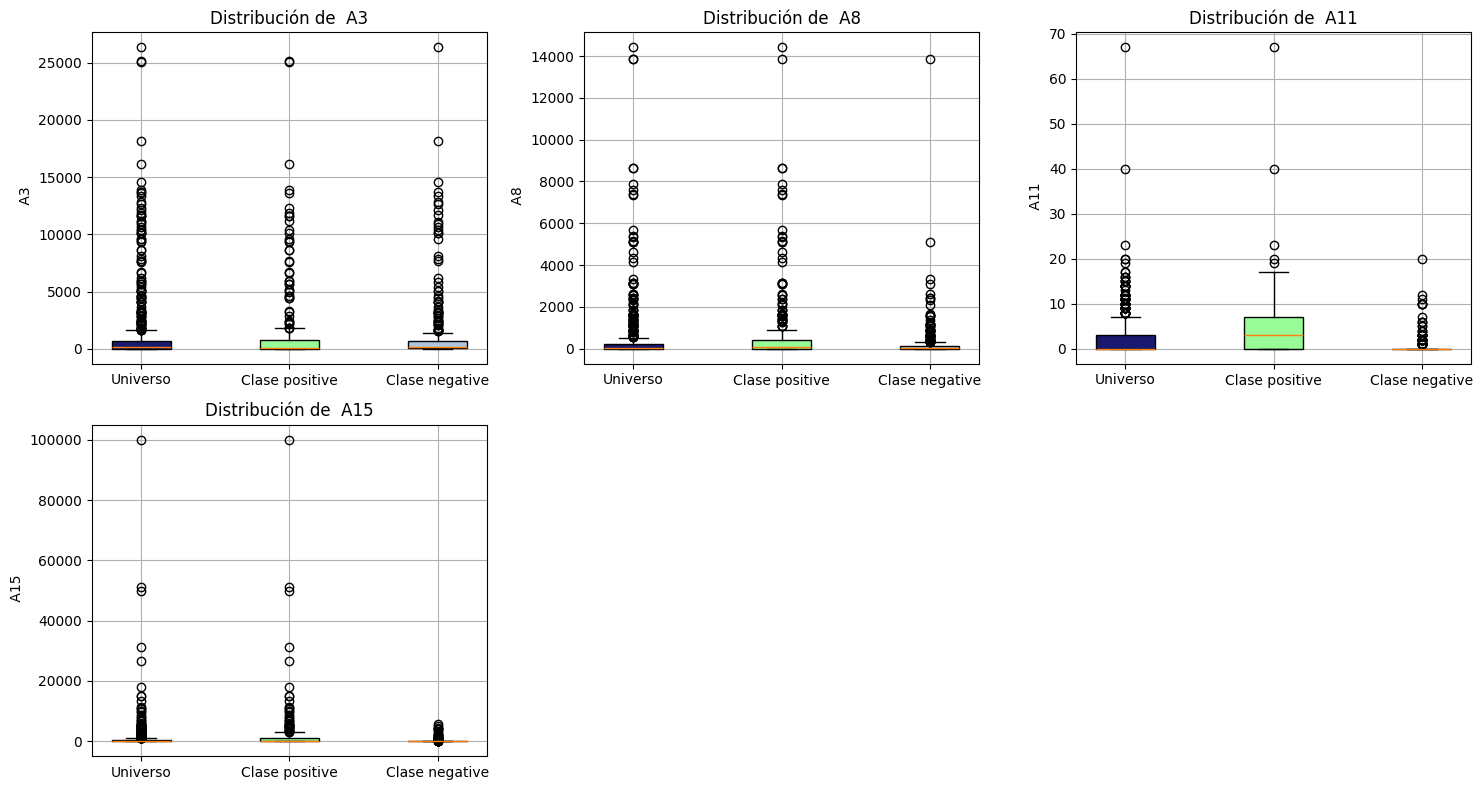

In [61]:
# Boxplot de los datos para analizar su distribución
plot_boxplots(df_pandas, ' Class')

Ahora para los datos categóricos se analiza como se distribuyen los valores por clase.

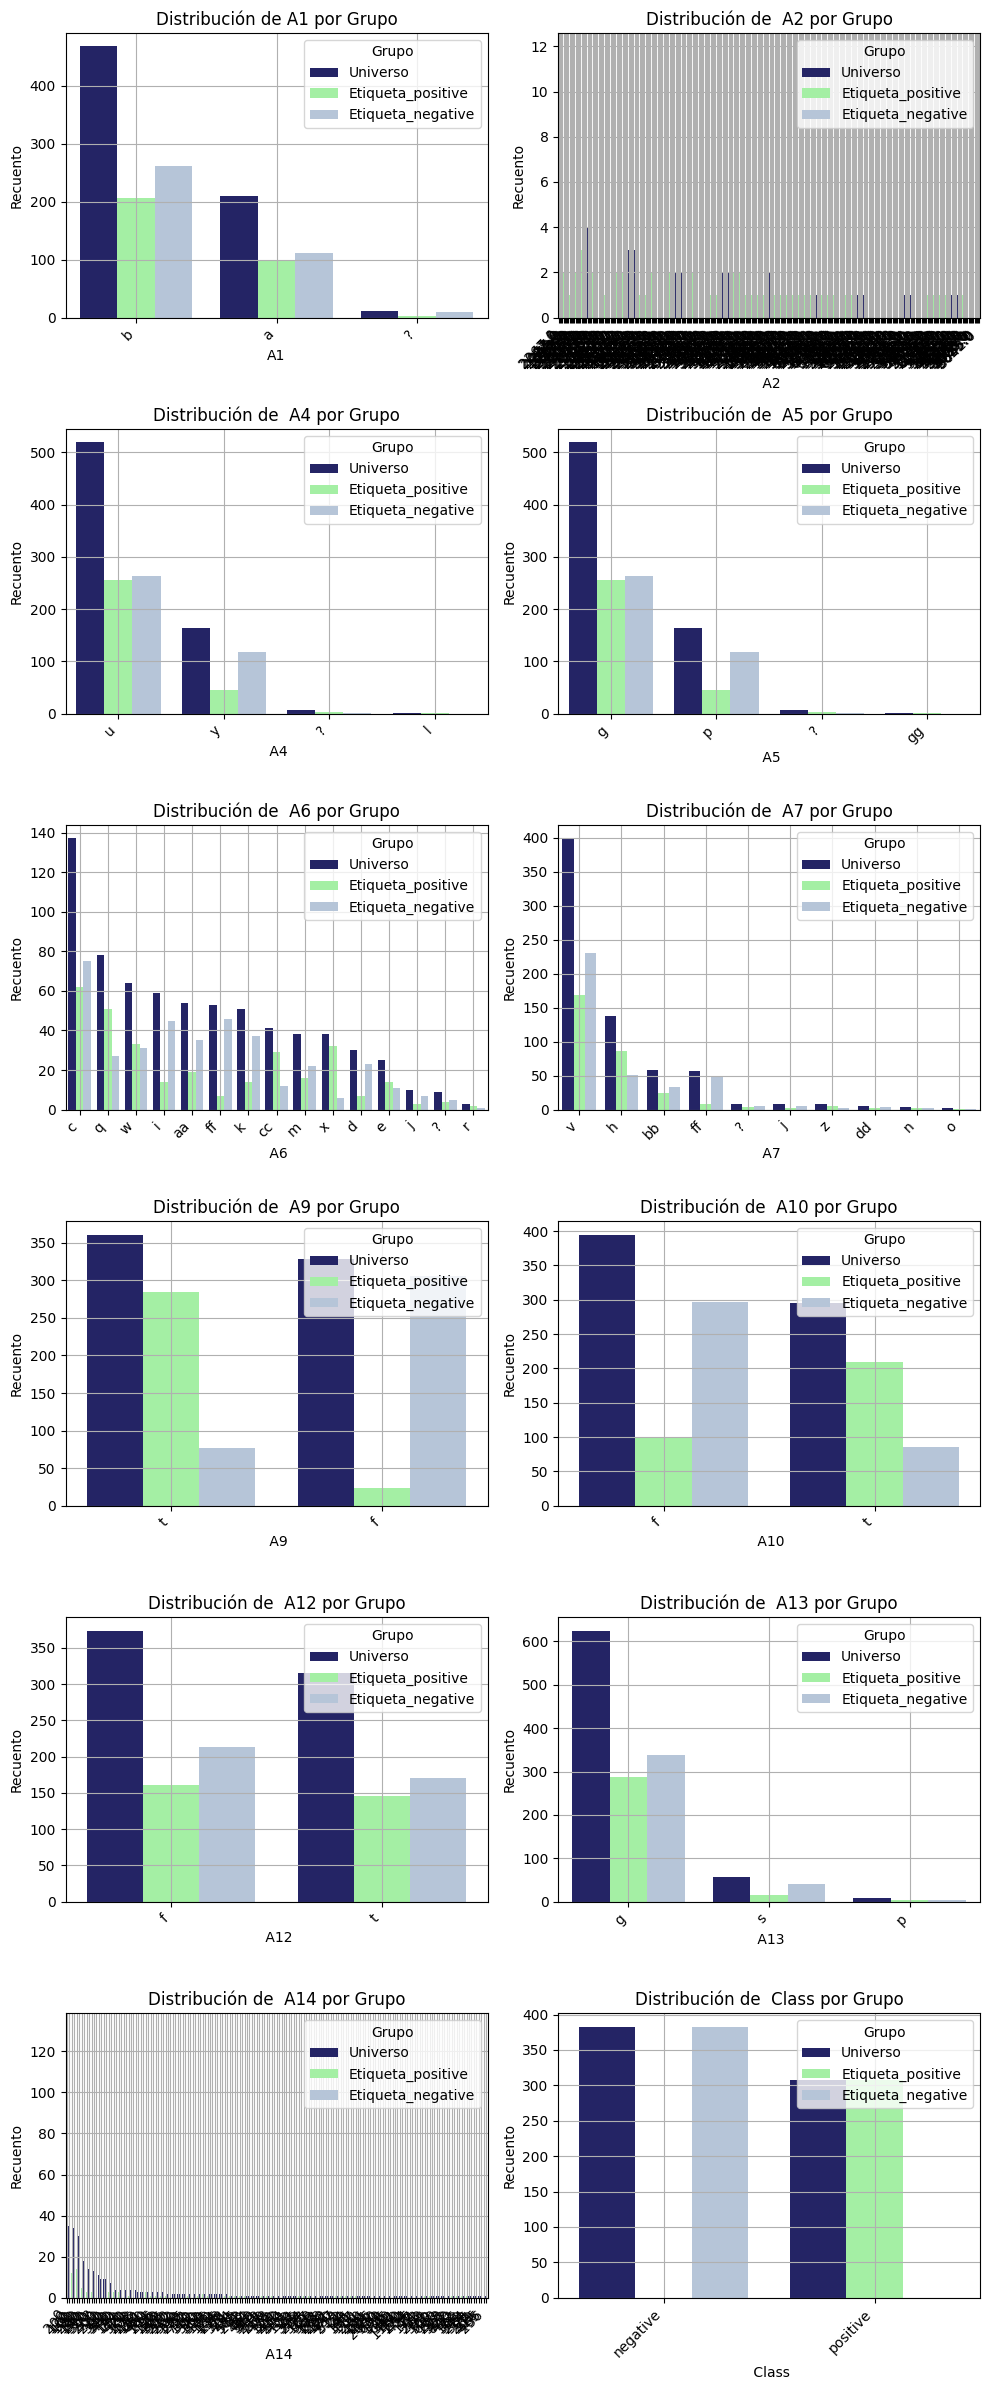

In [62]:
# Distribución de datos categóricos
plot_categoricalDistribution(df_pandas, ' Class')

Se analizan el porcentaje de valores nulos, tanto en el "universo" como en cada etiqueta.

In [64]:
# Ver porcentaje de valoresa nulos
plot_missingValues(df_pandas, ' Class')

El DataFrame no contiene columnas con valores nulos para analizar, excluyendo la columna de etiqueta.


 Análisis de patrones redundantes con $\phi_K$

El coeficiente $\phi_K$ es una medida de correlación que permite analizar relaciones entre variables
**categóricas, ordinales e intervalares**, capturando dependencias **lineales y no lineales**.
Su rango es:


$$0 \leq \phi_K \leq 1
$$

- **0** $\;\rightarrow\;$ no hay asociación.  
- **1** $\;\rightarrow\;$ asociación perfecta.  


**Base estadística**
$\phi_K$ se deriva de la prueba de independencia $\chi^2$ de Pearson en tablas de contingencia.  
Dadas frecuencias observadas $O_{ij}$ y esperadas $E_{ij}$, el estadístico es:

$$\chi^2 = \sum_{i=1}^r \sum_{j=1}^k \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

donde $r$ es el número de filas y $k$ el número de columnas.


**Interpretación**
- $\phi_K$ **generaliza a Pearson** ($\rho$) en distribuciones normales bivariadas.  
- Corrige las limitaciones de **Cramér’s V**, ya que no depende del número de bins.  
- Detecta patrones **redundantes** ($\phi_K$ alto entre variables $\;\Rightarrow\;$ una puede sobrar).  



**En práctica:** para depuración de datasets, se calcula $\phi_K$ entre todas las variables
y se eliminan aquellas con **$\phi_K \geq$ umbral** (ej. 0.7) respecto a otra,
ya que no aportan información nueva.


In [ ]:
plot_phiK(df_pandas)

interval columns not set, guessing: [' A3', ' A8', ' A11', ' A15']


Para eliminar los patrones redundantes se seguirá el siguiente proceso:

Para eliminar variables redundantes en el dataset, se sigue el siguiente proceso:

1. Se calcula la **matriz de correlación $\phi_K$** entre todas las variables.  
   - Esta métrica permite capturar relaciones lineales y no lineales entre variables numéricas o categóricas.  
   - Valores cercanos a **1** indican una alta redundancia.

2. Se establece un **umbral de correlación** (por defecto $0.7$).  
   - Si dos variables superan este umbral, se considera que aportan información redundante.  

3. **Criterios de eliminación jerárquica**:  
   - Si ambas variables son **categóricas**, se elimina la que tenga **mayor número de categorías distintas**
     (pues tiende a sobreajustar y ser menos generalizable).  
   - Si ambas tienen el mismo número de categorías, o son numéricas, se elimina la que presente
     **mayor promedio de correlación con el resto de variables** (la más redundante en general).  

4. El proceso se repite iterativamente hasta que no existan pares de variables con $\phi_K$ mayor al umbral definido.


Esto se hace para evitar el curso de la dimensionalidad.

## Parte 1, 2 y 3 ()

Con base a lo anterior se realizó el siguiente pipeline :
1. Imputación por clase.
2. Eliminación de columnas irrelevantes por Phi-K.
3. Tratamiento de outliers por clase usando IQR.
4. Conversión de la columna target a valores enteros (+1/-1).
5. One-hot encoding de columnas categóricas (excepto la etiqueta).

In [ ]:
data = pipeline_dataCleansing(df_pandas, 'class')

In [ ]:
print(data.head())

In [ ]:
imbalance_ratio(data, 'class')

## Parte 4 (Entrenamiento)

In [ ]:
resultados = entrenar_modelos(data)

## Parte 5 (Medidas de desempeño)

In [ ]:
resultados

In [ ]:
metricas_df, matrices = entrenar_modelos(data)

for nombre_modelo, lista_cms in matrices.items():
    print(f"Matriz de Confusión para {nombre_modelo}:")
    # Calcular la matriz de confusión promedio
    avg_cm = sum(lista_cms) / len(lista_cms)

    # Crear un DataFrame para la matriz de confusión con etiquetas
    cm_df = pd.DataFrame(avg_cm.astype(int), index=['Actual 1', 'Actual 0'], columns=['Predicted 1', 'Predicted 0'])

    # Reordenar para tener '1' en la parte superior izquierda y '0' en la inferior derecha
    cm_df = cm_df.loc[['Actual 1', 'Actual 0'], ['Predicted 1', 'Predicted 0']]

    display(cm_df)
    print("-" * 30)